In [1]:
import tensorflow as tf
from tensorflow import keras
from keras.layers import SimpleRNN, Dense, Dropout, LSTM
from tensorflow.keras.optimizers import Adam
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import matplotlib as mpl
import math 
from arch import arch_model
from arch.univariate import GARCH
import tensorflow_probability as tfp
import seaborn as sns
import tensorflow.math as m
pi = tf.constant(math.pi)
from sklearn.metrics import mean_squared_error as mse
from UTILS import nll

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (18,6)
plt.rcParams['font.size'] = 15

In [415]:
def nll(sigma2, r):
    return .5*m.reduce_sum(m.log(2*pi) + m.log(sigma2) + m.divide(r**2, sigma2))
def train_test_split_ts(ts, pct=.7):
    return (ts.iloc[:int(pct*ts.shape[0])], ts.iloc[int(pct*ts.shape[0]):])

class RNN(keras.Model):
    def __init__(self,
                 hiddens = [100, 1],
                 activation = 'relu',
                 optimizer= 'adam',
                 last_activation = 'relu'
                ):
        super().__init__()
        self.optimizer = optimizer
        self.activation = activation; self.last_activation = last_activation
        self.hiddens = hiddens
        self.initializer =  tf.keras.initializers.RandomNormal(mean=0.0, stddev=1)
        self.rnn = SimpleRNN(self.hiddens[0],
                             activation = self.activation,
                             kernel_initializer = self.initializer
                            )
        self.denses = []
        for size in self.hiddens[1:-1]:
            self.denses.append(Dense(size, activation = self.activation))
        self.denses.append(Dense(self.hiddens[-1], activation = self.last_activation))
        
    def call(self, x, train = True):
        out = self.rnn(x)
        for l in self.denses:
            out = l(out)
        if train:
            return out
        else:
            garch = arch_model(x, mean='Constant', vol='GARCH', p=1, q=1)
            fit = garch.fit(disp = False)
            self.garch_vola = tf.convert_to_tensor(
                fit.conditional_volatility.reshape(-1,1), dtype = 'float32'
            )
            return .5*out + .5*self.garch_vola           
            
    
    def train(self,
              x,
              epochs = 10,
              loss_fn = nll,
              use_rv = False
             ):
        #fit garch first
        print(30*'-'+'\nFITING THE GARCH MODEL\n'+30*'-')
        garch = arch_model(x, mean='Constant', vol='GARCH', p=1, q=1)
        fit = garch.fit(disp = False)
        self.fit = fit
        self.garch_vola = tf.convert_to_tensor(
            fit.conditional_volatility.reshape(-1,1), dtype = 'float32'
        )        
        #fit rnn after
        print(30*'-'+'\nFITING THE RNN\n'+30*'-')
        self.loss_to_plot = []
        self.compile(optimizer = self.optimizer, loss = loss_fn)
        for epoch in tqdm(range(epochs)):
            with tf.GradientTape() as tape:
                #model returns \sigma
                logits = self(x)
                loss = loss_fn((.5*logits + .5*self.garch_vola)**2, x[:,0,:])
            print(30*'-')
            print('EPOCH:{}'.format(epoch+1))
            print('NLL:{}'.format(loss))
            gradients = tape.gradient(loss, self.trainable_weights)
            self.optimizer.apply_gradients(zip(gradients, self.trainable_weights))
            self.loss_to_plot.append(loss.numpy())
    
    def plot_loss(self):
        plt.plot(self.loss_to_plot)

In [416]:
stock = yf.Ticker('^GSPC').history(start = '2010-01-01').Close
rets = 100*(stock.pct_change().dropna())
rets_train, rets_test = train_test_split_ts(rets, .7)
rets_train -= rets_train.mean()
rets_test -= rets_test.mean()

Data Statistics:

count    2.156000e+03
mean    -7.644370e-17
std      9.315907e-01
min     -6.711123e+00
5%      -1.554681e+00
50%      1.017191e-02
95%      1.394039e+00
max      4.693008e+00
Name: Close, dtype: float64


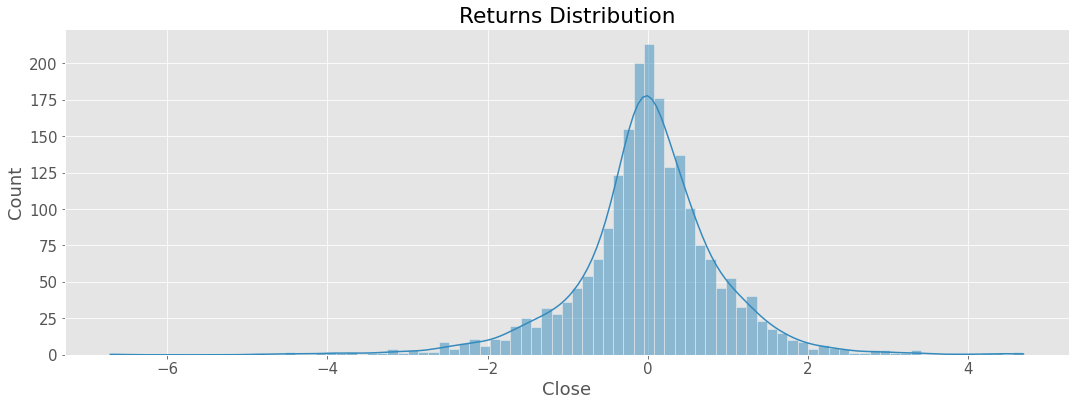

In [417]:
sns.histplot(rets_train,kde = True )
plt.title('Returns Distribution')
print('Data Statistics:\n\n{}'.format( rets_train.describe(percentiles = [.05, .5, .95])))
tf_rets_train = tf.expand_dims(tf.convert_to_tensor(rets_train.values.reshape(-1,1), dtype = 'float32'), 1)

Data Statistics:

count    9.250000e+02
mean     1.824366e-17
std      1.385757e+00
min     -1.204624e+01
5%      -2.026155e+00
50%      3.935921e-02
95%      1.596632e+00
max      9.320593e+00
Name: Close, dtype: float64


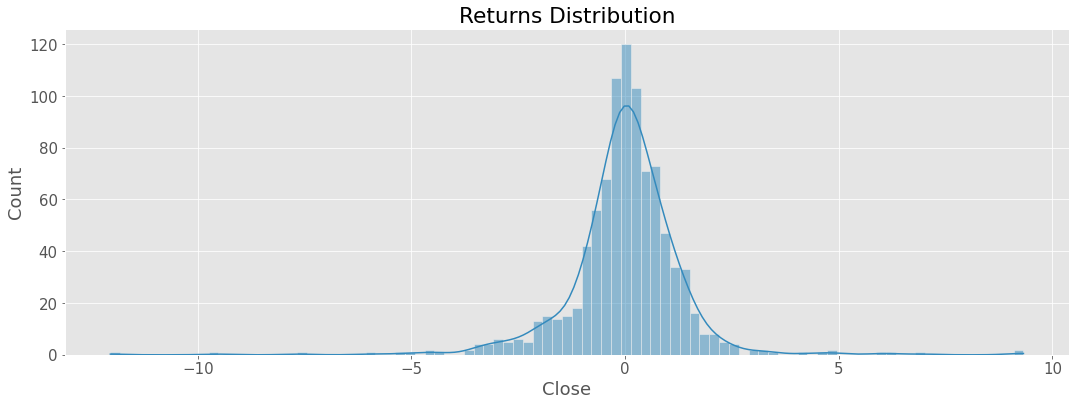

In [418]:
sns.histplot(rets_test,kde = True )
plt.title('Returns Distribution')
print('Data Statistics:\n\n{}'.format( rets_test.describe(percentiles = [.05, .5, .95])))
tf_rets_test = tf.expand_dims(tf.convert_to_tensor(rets_test.values.reshape(-1,1), dtype = 'float32'), 1)

In [419]:
model = RNN(
    hiddens=[100, 1],
    activation='tanh',
    optimizer='adam',
    last_activation='sigmoid'
)

In [420]:
model.train(
    tf_rets_train,
    epochs=600,
    loss_fn=nll,
    use_rv=False,
)

------------------------------
FITING THE GARCH MODEL
------------------------------
------------------------------
FITING THE RNN
------------------------------


  0%|          | 0/600 [00:00<?, ?it/s]

------------------------------
EPOCH:1
NLL:3523.89208984375
------------------------------
EPOCH:2
NLL:3508.91552734375
------------------------------
EPOCH:3
NLL:3493.188232421875
------------------------------
EPOCH:4
NLL:3476.66845703125
------------------------------
EPOCH:5
NLL:3459.31689453125
------------------------------
EPOCH:6
NLL:3441.096923828125
------------------------------
EPOCH:7
NLL:3421.97265625
------------------------------
EPOCH:8
NLL:3401.91064453125
------------------------------
EPOCH:9
NLL:3380.88427734375
------------------------------
EPOCH:10
NLL:3358.87255859375
------------------------------
EPOCH:11
NLL:3335.859375
------------------------------
EPOCH:12
NLL:3311.83984375
------------------------------
EPOCH:13
NLL:3286.81787109375
------------------------------
EPOCH:14
NLL:3260.81103515625
------------------------------
EPOCH:15
NLL:3233.8515625
------------------------------
EPOCH:16
NLL:3205.989501953125
------------------------------
EPOCH:17
NLL:3

------------------------------
EPOCH:139
NLL:2488.7041015625
------------------------------
EPOCH:140
NLL:2487.0908203125
------------------------------
EPOCH:141
NLL:2485.47412109375
------------------------------
EPOCH:142
NLL:2483.85205078125
------------------------------
EPOCH:143
NLL:2482.2265625
------------------------------
EPOCH:144
NLL:2480.597412109375
------------------------------
EPOCH:145
NLL:2478.964111328125
------------------------------
EPOCH:146
NLL:2477.326416015625
------------------------------
EPOCH:147
NLL:2475.68505859375
------------------------------
EPOCH:148
NLL:2474.0390625
------------------------------
EPOCH:149
NLL:2472.389404296875
------------------------------
EPOCH:150
NLL:2470.73486328125
------------------------------
EPOCH:151
NLL:2469.07666015625
------------------------------
EPOCH:152
NLL:2467.41455078125
------------------------------
EPOCH:153
NLL:2465.74755859375
------------------------------
EPOCH:154
NLL:2464.07666015625
--------------

------------------------------
EPOCH:273
NLL:2240.3720703125
------------------------------
EPOCH:274
NLL:2238.4248046875
------------------------------
EPOCH:275
NLL:2236.48046875
------------------------------
EPOCH:276
NLL:2234.5390625
------------------------------
EPOCH:277
NLL:2232.60009765625
------------------------------
EPOCH:278
NLL:2230.6640625
------------------------------
EPOCH:279
NLL:2228.7314453125
------------------------------
EPOCH:280
NLL:2226.801513671875
------------------------------
EPOCH:281
NLL:2224.87451171875
------------------------------
EPOCH:282
NLL:2222.950927734375
------------------------------
EPOCH:283
NLL:2221.03125
------------------------------
EPOCH:284
NLL:2219.115234375
------------------------------
EPOCH:285
NLL:2217.2021484375
------------------------------
EPOCH:286
NLL:2215.29345703125
------------------------------
EPOCH:287
NLL:2213.387939453125
------------------------------
EPOCH:288
NLL:2211.486328125
------------------------------

------------------------------
EPOCH:407
NLL:2031.5560302734375
------------------------------
EPOCH:408
NLL:2030.4915771484375
------------------------------
EPOCH:409
NLL:2029.43408203125
------------------------------
EPOCH:410
NLL:2028.3834228515625
------------------------------
EPOCH:411
NLL:2027.340087890625
------------------------------
EPOCH:412
NLL:2026.30419921875
------------------------------
EPOCH:413
NLL:2025.274169921875
------------------------------
EPOCH:414
NLL:2024.2518310546875
------------------------------
EPOCH:415
NLL:2023.236328125
------------------------------
EPOCH:416
NLL:2022.2275390625
------------------------------
EPOCH:417
NLL:2021.2255859375
------------------------------
EPOCH:418
NLL:2020.2298583984375
------------------------------
EPOCH:419
NLL:2019.241455078125
------------------------------
EPOCH:420
NLL:2018.260009765625
------------------------------
EPOCH:421
NLL:2017.284912109375
------------------------------
EPOCH:422
NLL:2016.316162109

------------------------------
EPOCH:543
NLL:1937.419921875
------------------------------
EPOCH:544
NLL:1937.004638671875
------------------------------
EPOCH:545
NLL:1936.592041015625
------------------------------
EPOCH:546
NLL:1936.1817626953125
------------------------------
EPOCH:547
NLL:1935.774658203125
------------------------------
EPOCH:548
NLL:1935.370361328125
------------------------------
EPOCH:549
NLL:1934.9683837890625
------------------------------
EPOCH:550
NLL:1934.5687255859375
------------------------------
EPOCH:551
NLL:1934.1724853515625
------------------------------
EPOCH:552
NLL:1933.77880859375
------------------------------
EPOCH:553
NLL:1933.386962890625
------------------------------
EPOCH:554
NLL:1932.998291015625
------------------------------
EPOCH:555
NLL:1932.6123046875
------------------------------
EPOCH:556
NLL:1932.228759765625
------------------------------
EPOCH:557
NLL:1931.847412109375
------------------------------
EPOCH:558
NLL:1931.46875
-

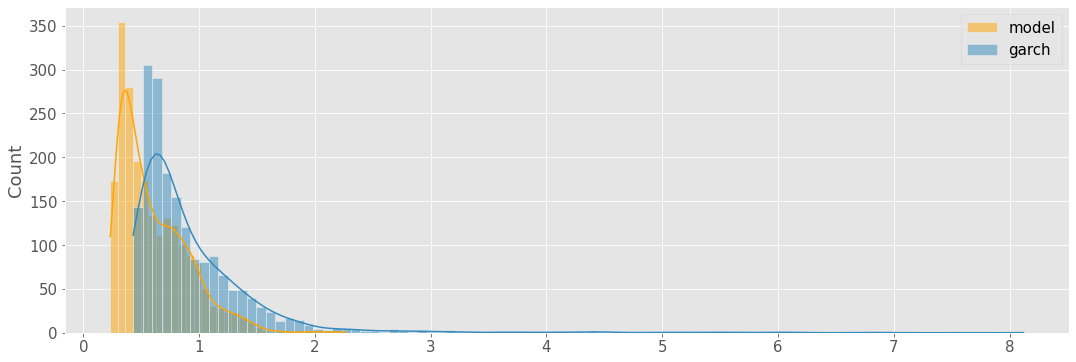

In [421]:
sns.histplot((model(tf_rets_train, train = False)).numpy().ravel(), label = 'model', kde = True, color = 'orange')
sns.histplot(fit.conditional_volatility, label = 'garch', kde = True)
plt.legend()

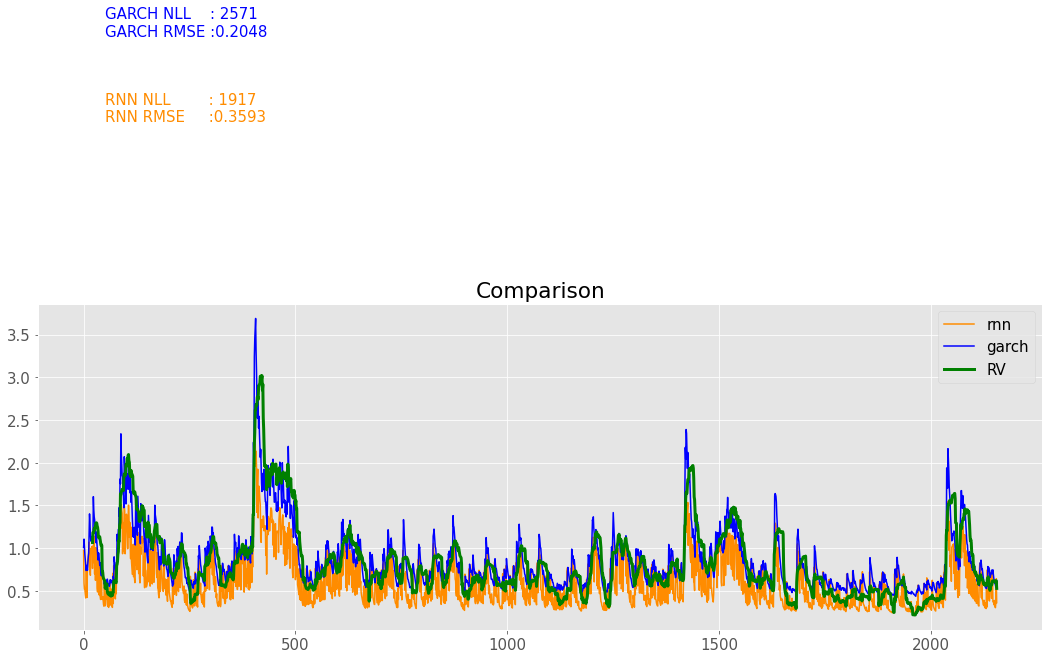

In [422]:
rv = rets_train.rolling(22).std().values

garch_nll = nll(model.garch_vola**2, tf_rets_train[:,0,:])
rnn_nll = nll(model(tf_rets_train, train=False)**2, tf_rets_train[:,0,:])

garch_rmse = mse(rv[21:], model.garch_vola[21:,0])**.5
rnn_rmse = mse(rv[21:], model(tf_rets_train, train = False)[21:,0])**.5

plt.plot(model(tf_rets_train, train = False), label = 'rnn', color = 'darkorange')
plt.plot(model.garch_vola, label = 'garch', color = 'blue')
plt.plot(rv, color = 'green', linewidth = 3, label = 'RV')
plt.legend()
plt.text(x = 50,
         y = 7,
         s = 'GARCH NLL    :{:5.0f}\nGARCH RMSE :{:1.4f}'.format(garch_nll, garch_rmse),
         color = 'blue'
        )
plt.text(x = 50,
         y = 6,
         s = 'RNN NLL        :{:5.0f}\nRNN RMSE     :{:1.4f}'.format(rnn_nll, rnn_rmse),
         color = 'darkorange'
        )
plt.title('Comparison')

plt.show()

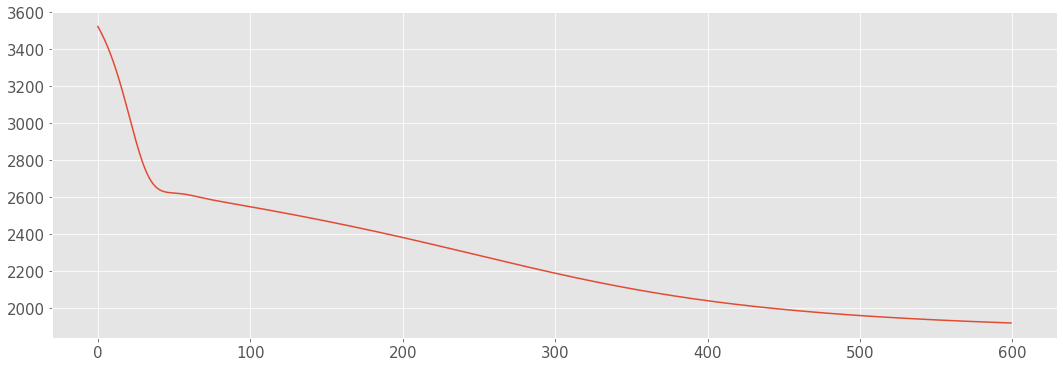

In [423]:
model.plot_loss()

In [436]:
model.fit.conditional_volatility[-1]

0.6184762247976389

In [ ]:
def forward_garch(rets, fit):
    mu, omega, alpha, beta = fit.params
    eps = rets-mu
    sigma = [fit.condtitional_volatility[-1]]
    for t in range(rets.shape[0]):
        sigma.append(omega+)
        #to be continued
        #you need to find epsilon_0

Text(0.5, 1.0, 'RNN O-O-S Volatility\nNLL: 1070')

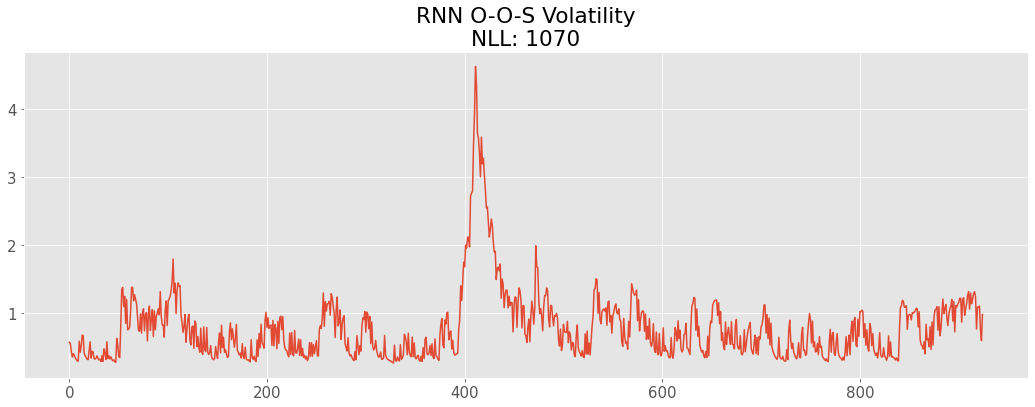

In [428]:
plt.plot(model(tf_rets_test, train=False))
plt.title('RNN O-O-S Volatility\nNLL:{:5.0f}'.format(
    nll(model(tf_rets_test, train=False)**2, tf_rets_test[:,0,:]))
         )

In [56]:
# #plt.plot(rets.iloc[21:], label = 'returns')
# plt.plot(train_ind, model(data)**.5, label = 'model ({:7.2f})'.format(-model.loss_to_plot[-1]))
# plt.plot(train_ind, fit.conditional_volatility,
#          label = 'garch ({:7.2f})'.format(fit.loglikelihood))
# # plt.plot(train_ind,tf_rv.numpy().ravel(), label = 'rv')
# #take a look on what you plot on garch nll later
# plt.plot()
# plt.text(x = train_ind[10], y = 0.8*max(model(data)**.5), s = 'GARCH VS RV RMSE:{:1.5f}'\
#          .format(mse(tf_rv.numpy().ravel(),fit.conditional_volatility) **.5),
#          fontsize = 'xx-large')
# plt.text(x = train_ind[10], y = .7*max(model(data)**.5), s = 'MODEL VS RV RMSE:{:1.5f}'\
#          .format(mse(tf_rv.numpy().ravel(), model(data)**.5)**.5), fontsize = 'xx-large')
# plt.legend()
# plt.show()